In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bottleneck as bn
import scipy as sc

In [2]:
def read_file(file_path):
    charges = []
    positions = []
    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate if we are in the ATOMS section
    in_atoms_section = False
    n_atoms = int(lines[3])

    # Loop through each line in the file
    for line in lines:
        # Check if the line starts with "ITEM: ATOMS"
        if line.startswith("ITEM: ATOMS"):
            in_atoms_section = True
            continue
        
        # If in the ATOMS section, extract the charge
        if in_atoms_section:
            if line.startswith("ITEM:"):  # If a new ITEM section starts, stop reading ATOMS
                in_atoms_section = False
            # Split the line by spaces and get the charge (last element)
            else:
                type = int(line.split()[1])
                charge = float(line.split()[-1])
                pos = np.array([float(x) for x in line.split()[2:5]])
                charges.append([charge,type])
                positions.append(pos)

    # Print the extracted charges
    charges=np.array(charges)
    positions = np.array(positions)
    charges =np.array([charges[i:i+n_atoms] for i in range(0, len(charges), n_atoms)])
    positions =np.array([positions[i:i+n_atoms] for i in range(0, len(positions), n_atoms)])
    return charges, positions
type = {1:"bottom wall", 2:"O", 3: "H",4:"Na", 5:"Cl", 6: "top wall"}  


def extract_polarisation(charges,positions):
    list = []
    for i in range(np.shape(charges)[0]):
        ind_top = charges[i,:,1]==1
        ind_bottom = charges[i,:,1]==6
        ind_O = charges[i,:,1]==2
        ind_H = charges[i,:,1]==3
        ind_Na = charges[i,:,1]==4
        ind_Cl = charges[i,:,1]==5

        charges_top = charges[i,ind_top,:]
        charges_bottom = charges[i,ind_bottom,:]
        charges_O = charges[i,ind_O,:]
        charges_H = charges[i,ind_H,:]
        charges_Na = charges[i,ind_Na,:]
        charges_Cl = charges[i,ind_Cl,:]

        position_O = positions[i,ind_O,:]
        position_H = positions[i,ind_H,:]
        position_Na = positions[i,ind_Na,:]
        position_Cl = positions[i,ind_Cl,:]
        dipole_O = np.sum(np.dot(charges_O[0,0],position_O),axis=0)
        dipole_H = np.sum(np.dot(charges_H[0,0],position_H),axis=0)
        dipole_Na = np.sum(np.dot(charges_Na[0,0],position_Na),axis=0)
        dipole_Cl = np.sum(np.dot(charges_Cl[0,0],position_Cl),axis=0)

        list.append([np.sum(charges_top[:,0]),np.sum(charges_bottom[:,0]),dipole_O,dipole_H,dipole_Na,dipole_Cl])
    return list

def plot_charge_top_wall(list, lf):
    start = list
    # plt.plot(start, label='data')
    plt.plot(bn.move_mean(start, window=100, min_count=1), label=f'move mean with lf = {lf}')
    def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
        return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty

    params = sc.optimize.curve_fit(exponential_fit, np.arange(len(start)), start, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    plt.plot(np.arange(len(start)), exponential_fit(np.arange(len(start)), *params[0]), label=f'fit with lf = {lf}')
    plt.legend()
    print(f"lf = {lf}; tau_water = {params[0][0]}, tau_ions = {params[0][1]}, Q_infty = {params[0][2]}, t_delay = {params[0][3]}, A = {params[0][4]}")
    plt.title("charge on the top wall")


def plot_polarisation(list, lf,c):
    dipole_water = []
    dipole_ions = []
    dipole_solutes = []
    for t in range(len(list)):
        dipole_water.append(np.linalg.norm(list[t][2][2]+list[t][3][2]))
        dipole_ions.append(np.linalg.norm(list[t][4][2]+list[t][5][2]))
        dipole_solutes.append(np.linalg.norm(list[t][4][2]+list[t][5][2]+list[t][2][2]+list[t][3][2]))
    # plt.plot(dipole_water, label='water')
    # plt.plot(bn.move_mean(dipole_water, window=100, min_count=1), label='smoothed water')
    # # plt.plot(dipole_ions, label='ions')
    # plt.plot(bn.move_mean(dipole_ions, window=100, min_count=1), label='smoothed ions')
    # plt.plot(dipole_solutes, label='solutes')
    print(dipole_solutes)
    plt.plot(bn.move_mean(dipole_solutes, window=100, min_count=1),color=c)
    plt.xlabel("time [0.1 ps]")
    plt.ylabel(r"$M_z [\AA e]$")
    def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
        return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty

    params_solute = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_solutes)), dipole_solutes, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    params_water = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_water)), dipole_water, maxfev=100000, method="dogbox", p0=[10,10,5,10,1])
    params_ions = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_ions)), dipole_ions, maxfev=100000, method="dogbox", p0=[10,10,5,10,1])
    plt.plot(np.arange(len(dipole_solutes)), exponential_fit(np.arange(len(dipole_solutes)), *params_solute[0]), label=f'lf = {lf}',color=c)
    # plt.plot(np.arange(len(dipole_water)), exponential_fit(np.arange(len(dipole_water)), *params_water[0]), label='fit water')
    # plt.plot(np.arange(len(dipole_ions)), exponential_fit(np.arange(len(dipole_ions)), *params_ions[0]), label='fit ions')
    # print(f"lf = {lf}; WATER ONLY:tau_water = {params_water[0][0]}, tau_ions = {params_water[0][1]}, Q_infty = {params_water[0][2]}, t_delay = {params_water[0][3]}, A = {params_water[0][4]}")
    # print(f"lf = {lf}; IONS ONLY: tau_water = {params_ions[0][0]}, tau_ions = {params_ions[0][1]}, Q_infty = {params_ions[0][2]}, t_delay = {params_ions[0][3]}, A = {params_ions[0][4]}")
    # print(f"lf = {lf}; BOTH: tau_water = {params_solute[0][0]}, tau_ions = {params_solute[0][1]}, Q_infty = {params_solute[0][2]}, t_delay = {params_solute[0][3]}, A = {params_solute[0][4]}")
    plt.legend(fontsize="small", loc ="lower right")
    return params_solute[0][0], params_solute[0][1], params_solute[0][2], params_solute[0][3], params_solute[0][4]

In [3]:
l=np.arange(0.5,5,0.5)
all_data = []

for i in l:
    if i%1<0.05:
        file_path = f'wallcharge_{i:.0f}.lammpstrj'
    else:
        file_path = f'wallcharge_{i:.1f}.lammpstrj'
    print("loading file"+file_path)
    charges, positions = read_file(file_path)
    print("loaded file"+file_path)
    list = extract_polarisation(charges,positions)
    all_data.append(list)
    # plot_polarisation(list, i)

loading filewallcharge_0.5.lammpstrj
loaded filewallcharge_0.5.lammpstrj
loading filewallcharge_1.lammpstrj
loaded filewallcharge_1.lammpstrj
loading filewallcharge_1.5.lammpstrj
loaded filewallcharge_1.5.lammpstrj
loading filewallcharge_2.lammpstrj
loaded filewallcharge_2.lammpstrj
loading filewallcharge_2.5.lammpstrj
loaded filewallcharge_2.5.lammpstrj
loading filewallcharge_3.lammpstrj
loaded filewallcharge_3.lammpstrj
loading filewallcharge_3.5.lammpstrj
loaded filewallcharge_3.5.lammpstrj
loading filewallcharge_4.lammpstrj
loaded filewallcharge_4.lammpstrj
loading filewallcharge_4.5.lammpstrj
loaded filewallcharge_4.5.lammpstrj


[18.678458886855708, 4.210391588867367, 1.854920194394154, 10.790126738788878, 18.103431287945938, 15.600113291161232, 25.02486216649696, 24.52255683018748, 32.1974836977099, 29.005439288544956, 32.405329484945156, 41.71176619886367, 46.92567302516189, 55.28508893874455, 47.29194338902191, 70.94733768790586, 70.56038548463397, 73.26911364491131, 70.87329371496307, 72.57317020093676, 69.47460970082653, 69.07389605956472, 70.48629658701722, 77.0195499917599, 80.2560478458531, 81.01716946936168, 83.4318608342297, 72.15047798882694, 73.48181551845518, 81.4462295663312, 92.36538845958275, 100.51745011635927, 104.642286239253, 109.34123876713952, 109.80207032076375, 117.31138451521099, 116.7199204983661, 120.02743299951959, 124.80543126794124, 122.01920676012028, 121.920453273508, 116.91106678598652, 132.705074939563, 125.07621972435568, 133.47788457463113, 129.60755009654028, 140.89982041496614, 140.8639434717972, 137.49643615529124, 144.85649304894895, 136.06342889539675, 137.6167503397762

/tmp/ipykernel_939363/3450370032.py:101: RuntimeWarning: overflow encountered in exp
  return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty
/tmp/ipykernel_939363/3450370032.py:101: RuntimeWarning: overflow encountered in multiply
  return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty


[9.900685503554516, 32.12722495553166, 39.68669529834827, 50.879584594591066, 50.40041439177058, 60.949395654156135, 65.23083967868723, 72.29940336443082, 74.63228835831194, 67.33404137474548, 70.24564042670238, 79.78332713213452, 66.97246633701829, 85.9289017220969, 87.07006554147344, 89.64714250257566, 99.83458447977873, 105.76347391432142, 115.98979166079526, 108.49547245859054, 114.95491444479713, 117.58354202918899, 122.12198711347392, 118.76263555430309, 118.47686235240874, 125.21483437402793, 122.18955835871932, 122.17138483644126, 130.22122273725137, 129.71702406487725, 123.12093121779202, 119.95071718059076, 124.8165218978776, 124.81099129095404, 126.80154209154972, 133.24053789441425, 125.75356721175469, 133.38345441933265, 138.08034285089894, 141.1974003412239, 140.0869925213259, 135.89176706485264, 140.90409204167668, 129.06982656391793, 128.90713331441614, 129.7795113499518, 124.42958180577014, 135.89415401490743, 144.83276231906626, 138.2646758672961, 133.70199344596085, 

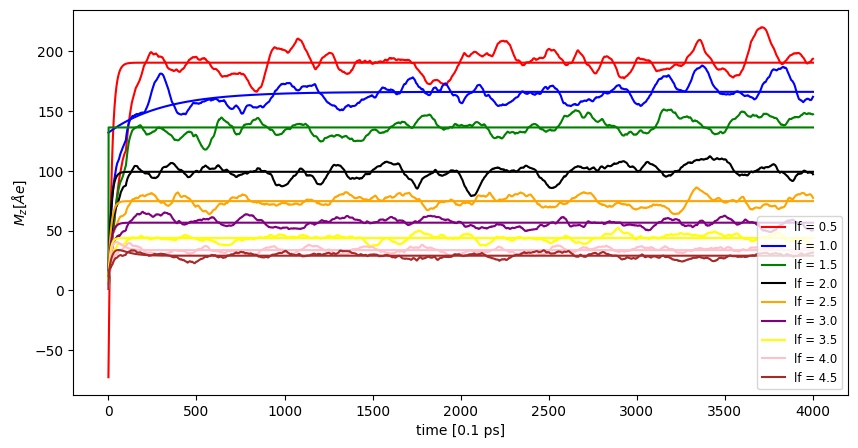

In [4]:
all_params=[]
plt.figure(figsize=(10,5))
colours = ["red","blue","green","black","orange","purple","yellow","pink","brown","grey"]
for i in range(len(all_data)):
    s = [all_data[i][j][:] for j in range(400,len(all_data[i]))]

    params = plot_polarisation(s, l[i],colours[i])
    all_params.append(params)

Text(0, 0.5, '$M_{z,\\infty} [\\AA e]$')

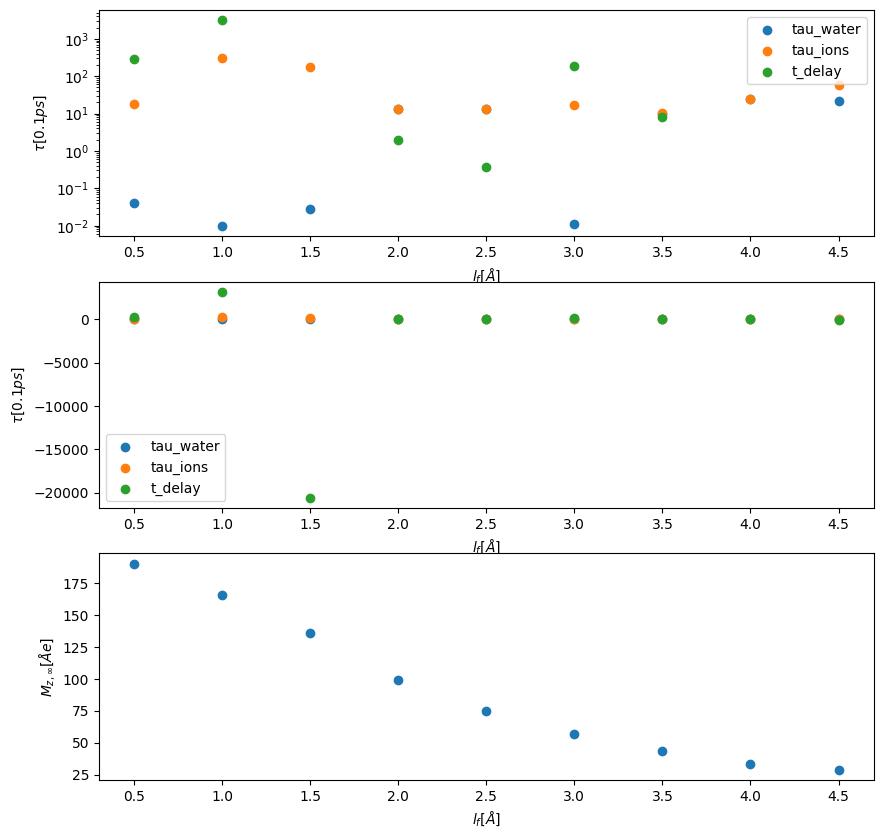

In [6]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].scatter(l, [x[0] for x in all_params], label="tau_water")
ax[0].scatter(l, [x[1] for x in all_params], label="tau_ions")
ax[0].scatter(l, [x[3] for x in all_params], label="t_delay")
ax[0].set_xlabel(r"$l_f [\AA]$")
ax[0].set_ylabel(r"$\tau [0.1 ps]$")
ax[0].set_yscale("log")
ax[0].legend()

ax[1].scatter(l, [x[0] for x in all_params], label="tau_water")
ax[1].scatter(l, [x[1] for x in all_params], label="tau_ions")
ax[1].scatter(l, [x[3] for x in all_params], label="t_delay")
ax[1].set_xlabel(r"$l_f [\AA]$")
ax[1].set_ylabel(r"$\tau [0.1 ps]$")

ax[1].legend()

ax[2].scatter(l, [x[2] for x in all_params], label="Q_infty")
ax[2].set_xlabel(r"$l_f [\AA]$")
ax[2].set_ylabel(r"$M_{z,\infty} [\AA e]$")